- performance inhibiting response to smoking related stimuli = correct nogo on smoking stim
- performance responding to health warning as go stim = accuracy, response time

In [1]:
import pandas as pd
import numpy as np
from config import (fname,
                    subject_ids, 
                    sessions, 
                    subj_interv, 
                    subj_control)

import pingouin as pg

/home/claire/.local/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.3.7.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
all_df=[]

for subj in subject_ids:
    for sess in sessions:
        metadata = pd.read_csv(fname.metadata_gng(subject='sub-'+ str(subj), session='ses-'+str(sess)))
        
        metadata['Subject']=str(subj)
        metadata['Session']=str(sess)
        
        if subj in subj_interv:
                metadata['Group']=str('int')

        elif subj in subj_control:
                metadata['Group']=str('ctr')

        all_df.append(metadata)

all_df = pd.concat(all_df)


move_to_front = ['Subject', 'Session', 'Group']
all_df = all_df[move_to_front + [col for col in all_df.columns if col not in move_to_front]]

In [4]:
all_df.head()

,Subject,Session,Group,Unnamed: 0,Unnamed: 0.1,onset,duration,trial_type,value,sample,filename,response_onset,response,type,accuracy
0,146,1,int,173,173,344.488,0.0,go,11,172244,HW_04.jpg,344.986,button press,go,correct
1,146,1,int,176,176,345.838,0.0,go,11,172919,SmoCuDa_198.jpg,346.202,button press,go,correct
2,146,1,int,179,179,347.122,0.0,nogo,13,173561,SmoCuDa_122.jpg,NaN,NaN,nogo,correct
3,146,1,int,181,181,348.688,0.0,go,11,174344,HW_39.jpg,348.994,button press,go,correct
4,146,1,int,184,184,349.936,0.0,go,11,174968,HW_13.jpg,350.298,button press,go,correct


In [4]:
all_df['accuracy'] = all_df['accuracy'].astype('category')

Performance inhibiting response to smoking related stimuli = correct nogo on smoking stim
---------

- count false alarm vs correct for each group and session

In [5]:
df_nogo_smk = all_df[(all_df['trial_type']=='nogo') & 
                     (all_df['filename'].str.startswith("SmoC"))]

False alarm per group and session:

In [6]:
df_nogo_smk.groupby(['Group', 'Session'])['accuracy'].apply(
    lambda x:  x [x.str.contains('false alarm')].count())

Group  Session
ctr    1          136
       2          149
int    1          137
       2          104
Name: accuracy, dtype: int64

False alarm rate per participant and session

In [7]:
df_nogo_smk.groupby(['Group', 'Session', 'Subject'])['accuracy'].count()

Group  Session  Subject
ctr    1        172        82
                185        82
                271        82
                279        82
                295        82
                           ..
int    2        743        82
                750        82
                754        82
                763        82
                786        82
Name: accuracy, Length: 88, dtype: int64

In [8]:
df_acc=df_nogo_smk.groupby(['Group', 'Session', 'Subject'], 
                           group_keys = False)['accuracy'].apply(
    lambda x: x[x.str.contains('false alarm')].count()/ 82*100)

In [9]:
df_acc

Group  Session  Subject
ctr    1        172         8.536585
                185         2.439024
                271         8.536585
                279        13.414634
                295        13.414634
                             ...    
int    2        743        10.975610
                750         2.439024
                754         6.097561
                763         1.219512
                786         6.097561
Name: accuracy, Length: 88, dtype: float64

In [10]:
# convert the series to dataframe and "remove" the grouping
df_acc=df_acc.to_frame()

df_acc=df_acc.reset_index()

In [11]:
df_acc

,Group,Session,Subject,accuracy
0,ctr,1,172,8.536585
1,ctr,1,185,2.439024
2,ctr,1,271,8.536585
3,ctr,1,279,13.414634
4,ctr,1,295,13.414634
...,...,...,...,...
83,int,2,743,10.975610
84,int,2,750,2.439024
85,int,2,754,6.097561
86,int,2,763,1.219512


In [137]:
pg.normality(data=df_acc, dv='accuracy', group='Group')

,W,pval,normal
ctr,0.675389,1.371136e-08,False
int,0.910402,2.308740e-03,False


In [20]:
df_acc.to_csv('df_nogo_smok_acc.csv')

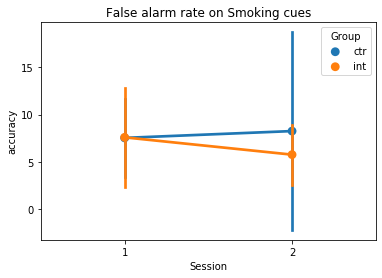

In [15]:
import seaborn as sns
sns_fig= sns.pointplot(data=df_acc, x= 'Session', y='accuracy', ci='sd', hue='Group')

sns_fig.set_title('False alarm rate on Smoking cues')


fig=sns_fig.get_figure()

fig.savefig(fname.figures_gng + '/Behaviour/' + 'fa_smok_plot_session.png')


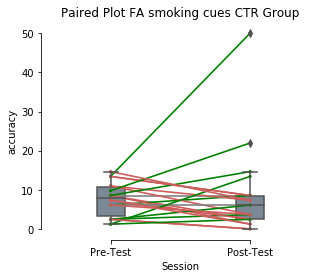

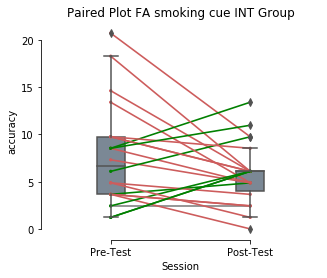

In [40]:
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4)) 

df_ctr=df_acc.query("Group == 'ctr'")
ctr_plot=pg.plot_paired(data=df_ctr, dv='accuracy', within='Session', 
                        subject= 'Subject', ax=ax1)
 
plt.title('Paired Plot FA smoking cues CTR Group')
plt.xticks(ticks=[0, 1], labels=['Pre-Test', 'Post-Test'])

fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4)) 

df_int=df_acc.query("Group == 'int'")
int_plot = pg.plot_paired(data=df_int, dv='accuracy', within='Session',
                          subject= 'Subject', ax=ax2)

plt.title('Paired Plot FA smoking cue INT Group')
plt.xticks(ticks=[0, 1], labels=['Pre-Test', 'Post-Test'])

fig1.savefig(fname.figures_gng + '/Behaviour/' +  'fa_smok_paired_plot_ctr.png')
fig2.savefig(fname.figures_gng + '/Behaviour/'+ 'fa_smok_hw_paired_plot_int.png')

Performance responding to health warning as go stim 
----------------------------------------------------------------------------------
- accuracy, response time

In [16]:
df_go_hw = all_df[(all_df['trial_type']=='go') & 
                     (all_df['filename'].str.startswith("HW"))]

In [38]:
df_go_hw.head()

,Subject,Session,Group,Unnamed: 0,Unnamed: 0.1,onset,duration,trial_type,value,sample,filename,response_onset,response,type,accuracy
0,146,1,int,173,173,344.488,0.0,go,11,172244,HW_04.jpg,344.986,button press,go,correct
3,146,1,int,181,181,348.688,0.0,go,11,174344,HW_39.jpg,348.994,button press,go,correct
4,146,1,int,184,184,349.936,0.0,go,11,174968,HW_13.jpg,350.298,button press,go,correct
7,146,1,int,192,192,354.202,0.0,go,11,177101,HW_31.jpg,354.634,button press,go,correct
8,146,1,int,195,195,355.486,0.0,go,11,177743,HW_34.jpg,355.730,button press,go,correct


In [17]:
df_go_hw['accuracy'].value_counts()

correct        17582
incorrect        458
false alarm        0
Name: accuracy, dtype: int64

In [18]:
df_go_hw['accuracy']=df_go_hw['accuracy'].cat.rename_categories({'incorrect':'miss'})

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [49]:
df_go_hw.tail()

,Subject,Session,Group,Unnamed: 0,Unnamed: 0.1,onset,duration,trial_type,value,sample,filename,response_onset,response,type,accuracy
560,786,2,int,1863,1863,1477.948,0.0,go,11,738974,HW_19.jpg,1478.372,button press,go,correct
561,786,2,int,1866,1866,1479.380,0.0,go,11,739690,HW_05.jpg,1479.788,button press,go,correct
566,786,2,int,1880,1880,1486.178,0.0,go,11,743089,HW_14.jpg,1486.484,button press,go,correct
569,786,2,int,1889,1889,1490.294,0.0,go,11,745147,HW_27.jpg,1490.676,button press,go,correct
572,786,2,int,1898,1898,1494.258,0.0,go,11,747129,HW_01.jpg,1494.756,button press,go,correct


Correct accuracy per group and sessio

In [19]:
df_go_hw.groupby(['Group', 'Session'])['accuracy'].apply(
    lambda x:  x [x.str.contains('correct')].count())

Group  Session
ctr    1          4412
       2          4352
int    1          4407
       2          4411
Name: accuracy, dtype: int64

Accuracy rate per participants per session

In [20]:
df_go_hw.groupby(['Group', 'Session', 'Subject'])['accuracy'].count()

Group  Session  Subject
ctr    1        172        205
                185        205
                271        205
                279        205
                295        205
                          ... 
int    2        743        205
                750        205
                754        205
                763        205
                786        205
Name: accuracy, Length: 88, dtype: int64

In [21]:
df_acc_hw=df_go_hw.groupby(['Group', 'Session', 'Subject'], 
                           group_keys = False)['accuracy'].apply(
    lambda x: x[x.str.contains('correct')].count()/ 205*100)

In [22]:
# convert the series to dataframe and "remove" the grouping
df_acc_hw=df_acc_hw.to_frame()

df_acc_hw=df_acc_hw.reset_index()

In [23]:
df_acc_hw

,Group,Session,Subject,accuracy
0,ctr,1,172,94.146341
1,ctr,1,185,100.000000
2,ctr,1,271,96.585366
3,ctr,1,279,99.512195
4,ctr,1,295,93.658537
...,...,...,...,...
83,int,2,743,98.048780
84,int,2,750,97.560976
85,int,2,754,100.000000
86,int,2,763,98.536585


In [24]:
pg.normality(data=df_acc_hw, dv='accuracy', group='Group')

,W,pval,normal
ctr,0.346627,9.772836e-13,False
int,0.789631,1.749826e-06,False


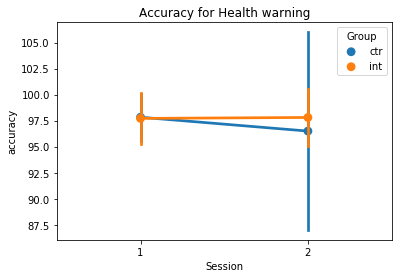

In [25]:
import seaborn as sns
sns_fig= sns.pointplot(data=df_acc_hw, x= 'Session', y='accuracy', ci='sd', hue='Group')

sns_fig.set_title('Accuracy for Health warning')


fig=sns_fig.get_figure()

fig.savefig(fname.figures_gng + '/Behaviour/' + 'accuracy_hw_plot_session.png')


In [57]:
df_acc_hw.to_csv('df_acc_hw.csv')

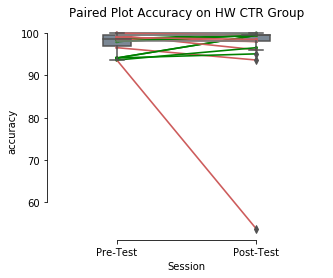

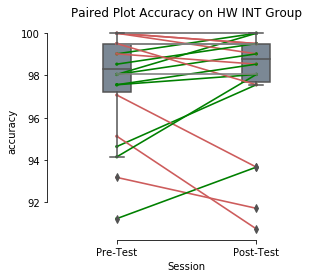

In [42]:
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4)) 

df_ctr=df_acc_hw.query("Group == 'ctr'")
ctr_plot=pg.plot_paired(data=df_ctr, dv='accuracy', within='Session', 
                        subject= 'Subject', ax=ax1)
 
plt.title('Paired Plot Accuracy on HW CTR Group')
plt.xticks(ticks=[0, 1], labels=['Pre-Test', 'Post-Test'])

fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4)) 

df_int=df_acc_hw.query("Group == 'int'")
int_plot = pg.plot_paired(data=df_int, dv='accuracy', within='Session',
                          subject= 'Subject', ax=ax2)

plt.title('Paired Plot Accuracy on HW INT Group')
plt.xticks(ticks=[0, 1], labels=['Pre-Test', 'Post-Test'])

fig1.savefig(fname.figures_gng + '/Behaviour/' +  'acc_hw_paired_plot_ctr.png')
fig2.savefig(fname.figures_gng + '/Behaviour/'+ 'acc_hw_paired_plot_int.png')

Response time to HW stim as Go
------------------------------------------------

In [29]:
df_rt_hw = all_df[(all_df['trial_type']=='go') & 
                     (all_df['filename'].str.startswith("HW")) & 
                  (all_df['accuracy']=='correct')]

In [30]:
df_rt_hw['accuracy'].value_counts()

correct        17582
incorrect          0
false alarm        0
Name: accuracy, dtype: int64

In [62]:
df_rt_hw.columns

Index(['Subject', 'Session', 'Group', 'Unnamed: 0', 'Unnamed: 0.1', 'onset',
       'duration', 'trial_type', 'value', 'sample', 'filename',
       'response_onset', 'response', 'type', 'accuracy'],
      dtype='object')

In [31]:
df_rt_hw['resp_time'] = df_rt_hw['response_onset'] - df_rt_hw['onset']

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
df_rt_hw['resp_time']

0      0.498
3      0.306
4      0.362
7      0.432
8      0.244
       ...  
560    0.424
561    0.408
566    0.306
569    0.382
572    0.498
Name: resp_time, Length: 17582, dtype: float64

In [33]:
# compute the mean RT by participant
df_rt_mean=df_rt_hw.groupby(['Group','Session', 'Subject'])['resp_time'].mean()

# convert the series to dataframe and "remove" the grouping
df_rt_mean=df_rt_mean.to_frame()

df_rt_mean=df_rt_mean.reset_index()
df_rt_mean

In [86]:
pg.normality(data=df_rt_hw, dv='resp_time', group='Group')

/home/claire/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,W,pval,normal
int,0.965578,1.941219e-41,False
ctr,0.947690,0.000000e+00,False


In [87]:
df_rt_mean.to_csv('df_rt_hw_gng.csv')

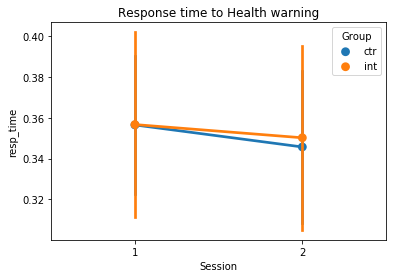

In [35]:
import seaborn as sns
sns_fig= sns.pointplot(data=df_rt_mean, x= 'Session', y='resp_time', ci='sd', hue='Group')

sns_fig.set_title('Response time to Health warning')


fig=sns_fig.get_figure()

fig.savefig(fname.figures_gng + '/Behaviour/' + 'resp_time_hw_plot_session.png')


In [36]:
import matplotlib.pyplot as plt


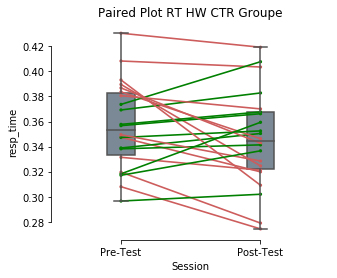

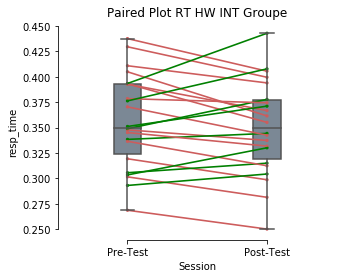

In [39]:
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4)) 

df_ctr=df_rt_hw.query("Group == 'ctr'")
ctr_plot=pg.plot_paired(data=df_ctr, dv='resp_time', within='Session', 
                        subject= 'Subject', ax=ax1)
 
plt.title('Paired Plot RT HW CTR Groupe')
plt.xticks(ticks=[0, 1], labels=['Pre-Test', 'Post-Test'])

fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4)) 

df_int=df_rt_hw.query("Group == 'int'")
int_plot = pg.plot_paired(data=df_int, dv='resp_time', within='Session',
                          subject= 'Subject', ax=ax2)

plt.title('Paired Plot RT HW INT Groupe')
plt.xticks(ticks=[0, 1], labels=['Pre-Test', 'Post-Test'])

fig1.savefig(fname.figures_gng + '/Behaviour/' +  'resp_time_hw_paired_plot_ctr.png')
fig2.savefig(fname.figures_gng + '/Behaviour/'+ 'resp_time_hw_paired_plot_int.png')

In [ ]:
x= 

pg.plot_shift()

In [100]:
x=df_ctr.loc[df_ctr['Session'] == '1', 'resp_time']
y=df_int.loc[df_int['Session'] == '1', 'resp_time']

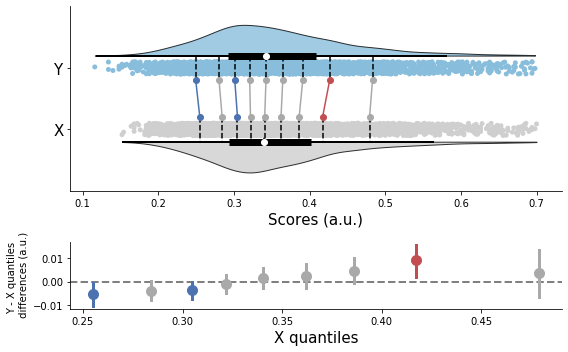

In [102]:
fig_pre=pg.plot_shift(x, y)

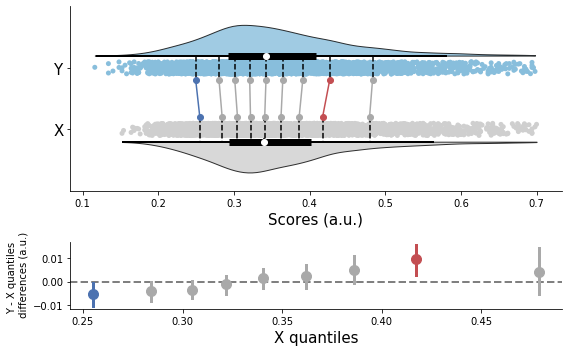

In [103]:
x2=df_ctr.loc[df_ctr['Session'] == '2', 'resp_time']
y2=df_int.loc[df_int['Session'] == '2', 'resp_time']

fig_post=pg.plot_shift(x, y)